# Signature-Based Two Sample Hypothesis Testing

## Scaled Brownian Motion - Gradient Computation

### Andrew Alden

### Table of Contents

- [Initial Setup](#initial-setup)
- [Compute Gradient under Alternative Hypothesis ](#grad-H1)
- [Compute Gradient under Null Hypothesis](#grad-H0)

## Initial Setup <a class="anchor" id="initial-setup"></a>

### Change working directory to root folder

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

### Import libraries 

In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from pathlib import Path


from src.utils.plotting_functions import construct_plot, compute_ci


from src.mmd.distribution_functions import return_mmd_distributions, expected_type2_error
from src.mmd.mmd import SigKernel, LinearKernel
from src.mmd.scaled_bm_stats import *
from src.mmd.two_sample_stats import *
from src.mmd.type2_grad import *

from src.StochasticProcesses.ScaledBM import generate_scaled_brownian_motion_paths


In [6]:
import sys
import types

numpy_core_fake = types.ModuleType("numpy._core")
sys.modules["numpy._core"] = numpy_core_fake

numpy_core_fake.multiarray = np.core.multiarray
numpy_core_fake.numeric = np.core.numeric
numpy_core_fake.umath = np.core.umath

sys.modules["numpy._core.multiarray"] = np.core.multiarray
sys.modules["numpy._core.numeric"] = np.core.numeric
sys.modules["numpy._core.umath"] = np.core.umath

### Set device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Signature Kernel

In [4]:
dyadic_order  = 0
static_kernel = LinearKernel()

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

## Compute Gradient under Alternative Hypothesis <a class="anchor" id="grad-H1"></a>

In [9]:
def generate_grad(h0_paths, h1_paths, scaling_range, xi_list, n_paths_list, signature_kernel, 
                  h=0.1, n_atoms=100, alpha=0.05, _k=6, num_sim=10, verbose=True, device='cpu'):
    
    """
    Compute gradients of the critical value and P[Type 2 Error] using closed-form formula and finite difference. 
    :param h0_paths: Collection of paths under H0.
    :param h1_paths: Collection of paths under H1.
    :param scaling_range: List of scaling values. 
    :param xi_list: List of sigmoid smoothing parameter values.
    :param n_paths_list: List of collection sizes.
    :param signature_kernel: Sig-MMD object to compute the test statistic.
    :param h: Finite difference offset. Default is 0.1.
    :param n_atoms: Number of batches to compute empirical CDF. Default is 100.
    :param alpha: Level of the test. Default is 0.05.
    :param _k: Signature truncation level. Default is 6.
    :param num_sim: Number of simulations. Default is 10.
    :param verbose: Boolean indicating whether to display progress when computing the sig-MMD. Default is True.
    :param device: Device on which to perform computations. Default is 'cpu'.
    :return: This function returns 6 dictionaries, each dictionary indexed by the elements in n_paths_list. Each value
             in the dictionary is a list containing results from independent simulations or, when the gradients were
             computed using the closed-form formulae, the values are themselves dictionaries. In this case the keys
             of the nested dictionaries correspond to the sigmoid smoothing parameters and values being lists 
             containing independent simulations. The dictionaries are as follows:
             1) critval_grad_fd -> Gradients of critical value computed using the finite difference method
             2) type2error_grad_fd -> Gradients of P[Type 2 Error] computed using the finite difference method
             3) critval_grad_emp -> Gradients of critical value using the closed-form formula
             4) type2error_grad_emp -> Gradients of P[Type 2 Error] computed using the closed-form formula
             5) crit_val_dict -> Critical values
             6) prob_type2_dict -> P[Type 2 Error]
    """

    type2error_grad_fd = defaultdict(list)
    type2error_grad_emp = defaultdict(list)
    crit_val_dict = defaultdict(list)
    prob_type2_dict = defaultdict(list)
    critval_grad_fd = defaultdict(list)
    critval_grad_emp = defaultdict(list)

    error_fn = lambda x, y: expected_type2_error(torch.tensor(x), y).item()    
    
    for n_paths in n_paths_list:
        
        for scaling in scaling_range:
    
            crit_val_fd_list = []
            crit_val_emp_list = defaultdict(list)
            prob_type2_list = []
            crit_val_list = []
            type2_grad_fd_list = []
            type2_grad_emp_list = defaultdict(list)

            if verbose:
                sim_iterator = tqdm(range(num_sim))
            else:
                sim_iterator = range(num_sim)
    
            for _ in sim_iterator:
            
                h0_dists, h1_dists, rand_ints = return_mmd_distributions(
                    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths), 
                    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths), 
                    signature_kernel.compute_mmd, 
                    n_atoms=n_atoms, 
                    batch_size=n_paths, 
                    estimator='ub', 
                    verbose=False
                )
                
                crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]
                
                h0_dists_fd, h1_dists_fd, _ = return_mmd_distributions(
                    torch.multiply(torch.Tensor([scaling+h, 1]).to(device=device), h0_paths), 
                    torch.multiply(torch.Tensor([scaling+h, 1]).to(device=device), h1_paths), 
                    signature_kernel.compute_mmd, 
                    n_atoms=n_atoms, 
                    batch_size=n_paths, 
                    estimator='ub', 
                    rand_ints=rand_ints, 
                    verbose=False
                )
                
                crit_val_fd = np.sort(np.asarray(h0_dists_fd))[int(n_atoms*(1-alpha))]
            
                type2_grad_fd_list.append((error_fn(h1_dists_fd, crit_val_fd) - error_fn(h1_dists, crit_val))/(1*h))
                crit_val_fd_list.append((crit_val_fd-crit_val)/h)
        
                crit_val_list.append(crit_val)
                prob_type2_list.append(error_fn(h1_dists, crit_val))
    
                for xi_1 in xi_list:
                    xi_2 = xi_1
                    type2_grad, crit_val_grad = scaling_grad(
                        torch.multiply(torch.Tensor([1, 1/scaling]).to(device=device), h0_paths),
                        torch.multiply(torch.Tensor([1, 1/scaling]).to(device=device), h1_paths), 
                        crit_val,
                        h1_dists,
                        h0_dists,
                        xi_1, 
                        rand_ints,
                        scaling,
                        _k, 
                        xi_2=xi_2, 
                        scaling_mult=False, 
                        print_res=False, 
                        device=device, 
                        verbose=False)
                    type2_grad_emp_list[xi_1].append(type2_grad)
                    crit_val_emp_list[xi_1].append(crit_val_grad * 2 * scaling)
    
            critval_grad_fd[n_paths].append(crit_val_fd_list)
            type2error_grad_fd[n_paths].append(type2_grad_fd_list)
    
            critval_grad_emp[n_paths].append(crit_val_emp_list)
            type2error_grad_emp[n_paths].append(type2_grad_emp_list)
    
            crit_val_dict[n_paths].append(crit_val_list)
            prob_type2_dict[n_paths].append(prob_type2_list)
    return critval_grad_fd, type2error_grad_fd, critval_grad_emp, type2error_grad_emp, crit_val_dict, prob_type2_dict

In [ ]:
sig = 0.25
beta = 0.35

T           = 1
grid_points = 39

path_bank_size = 10000

num_sim = 50
   
h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)

n_paths_list = [20, 60, 120]
xi_list = [1, 20, 100]
scaling_range = np.linspace(0.1, 4, 15)

critval_grad_fd, type2error_grad_fd, critval_grad_emp, type2error_grad_emp, crit_val_dict, prob_type2_dict = generate_grad(h0_paths,
                                                                                                                           h1_paths, 
                                                                                                                           scaling_range,
                                                                                                                           xi_list,
                                                                                                                           n_paths_list, 
                                                                                                                           signature_kernel, 
                                                                                                                           num_sim=num_sim, 
                                                                                                                           verbose=True, 
                                                                                                                           device=device)

 Save simulations.

In [17]:
with open('ScaledBMData/grad_mmd_computations_scaledbm_025_035.pkl', 'wb') as f:
    pickle.dump([critval_grad_fd, type2error_grad_fd, critval_grad_emp, type2error_grad_emp, crit_val_dict, prob_type2_dict], f)

Load simulations. 

In [24]:
with open('ScaledBMData/grad_mmd_computations_scaledbm_025_035.pkl', 'rb') as f:
    grad_data = pickle.load(f)

critval_grad_fd = grad_data[0]
type2error_grad_fd = grad_data[1]
critval_grad_emp = grad_data[2]
type2error_grad_emp = grad_data[3]
crit_val_dict = grad_data[4]
prob_type2_dict = grad_data[5]

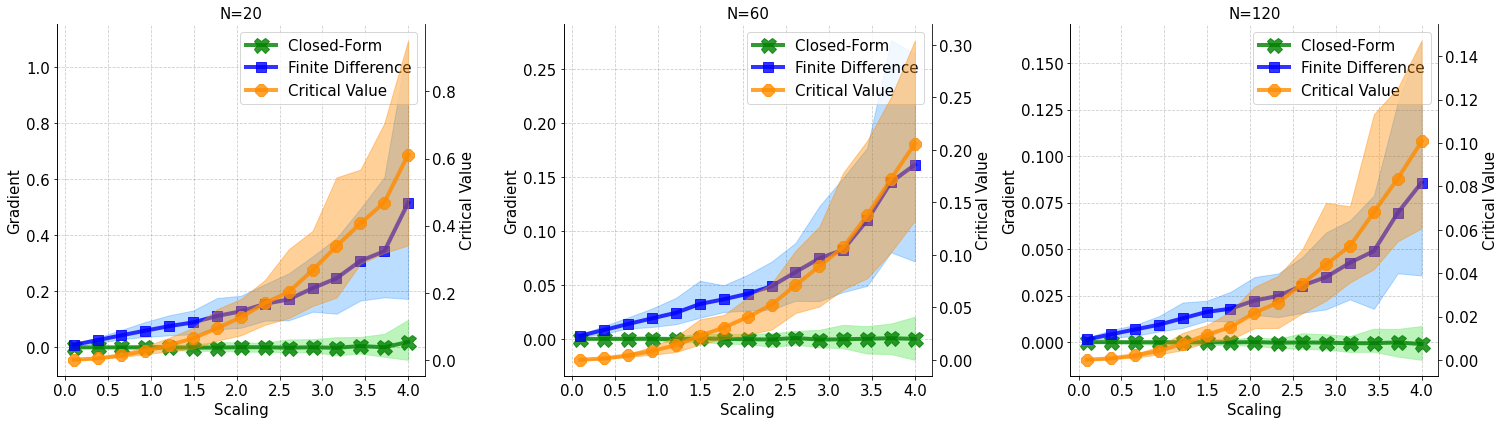

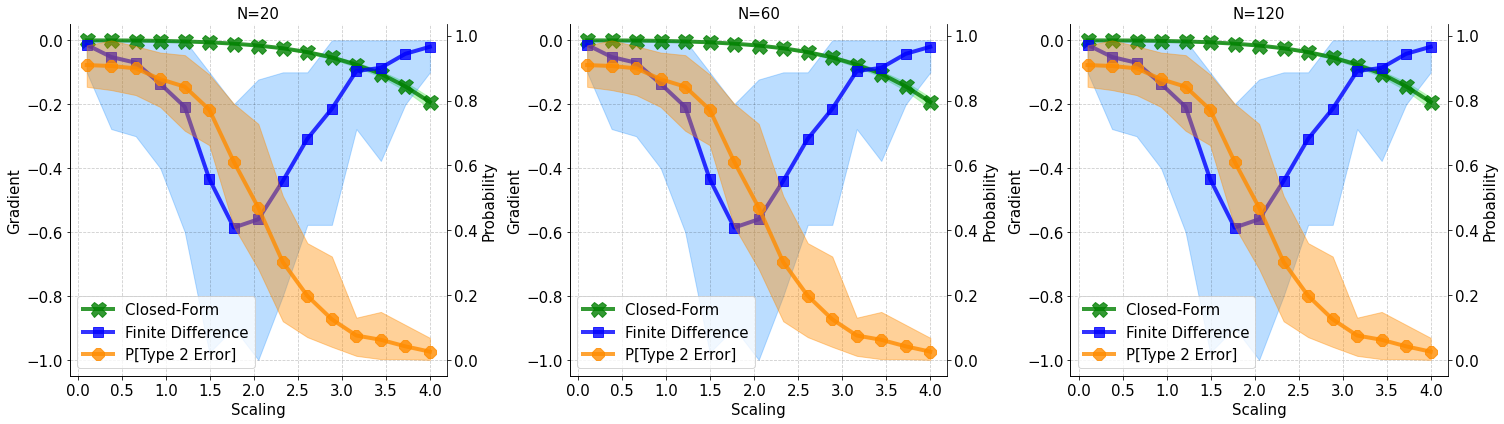

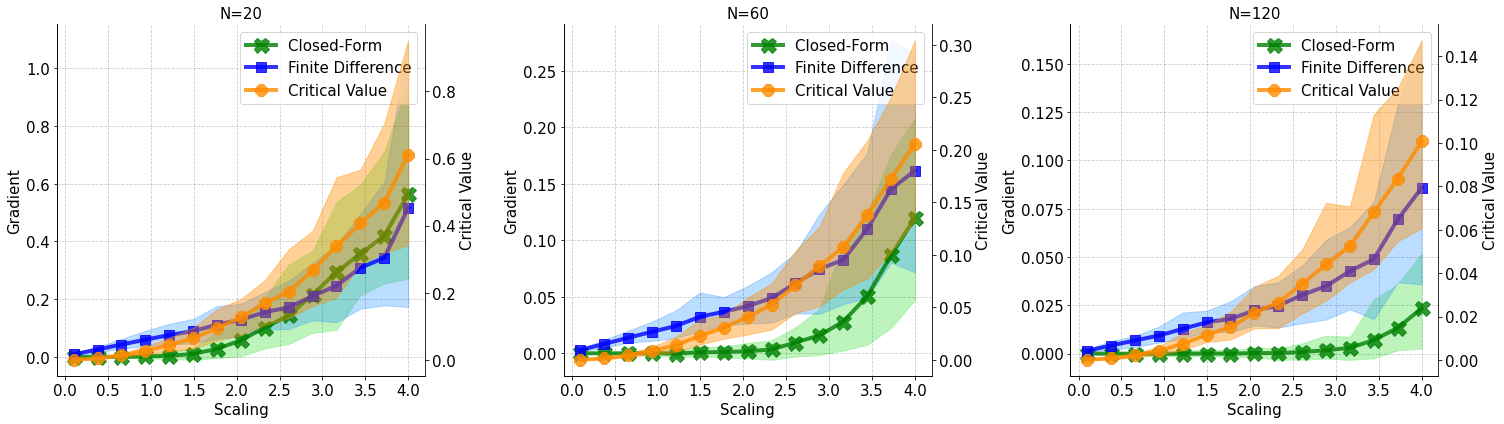

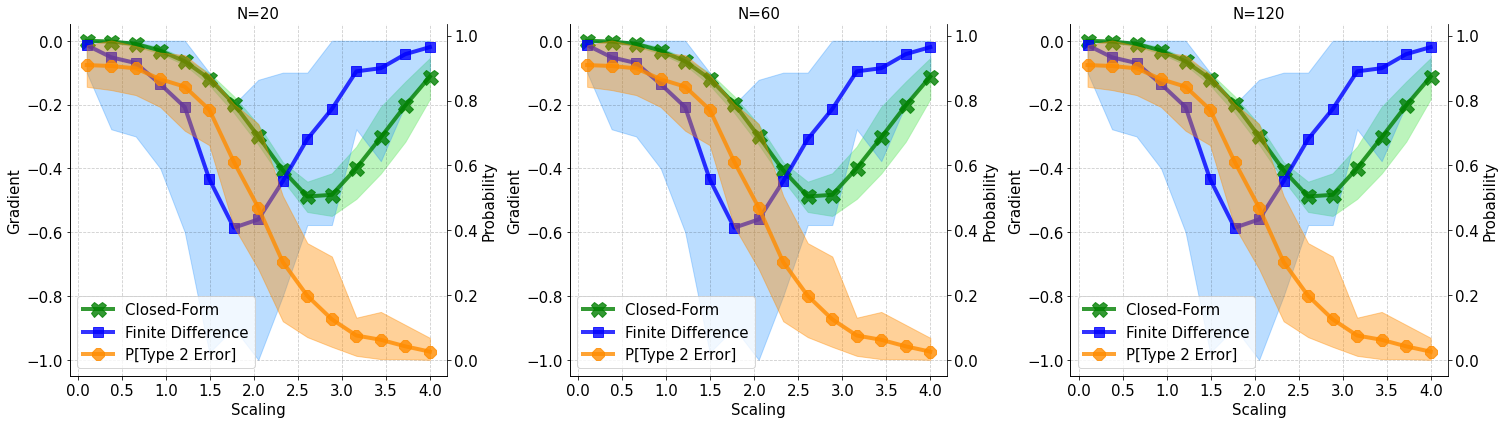

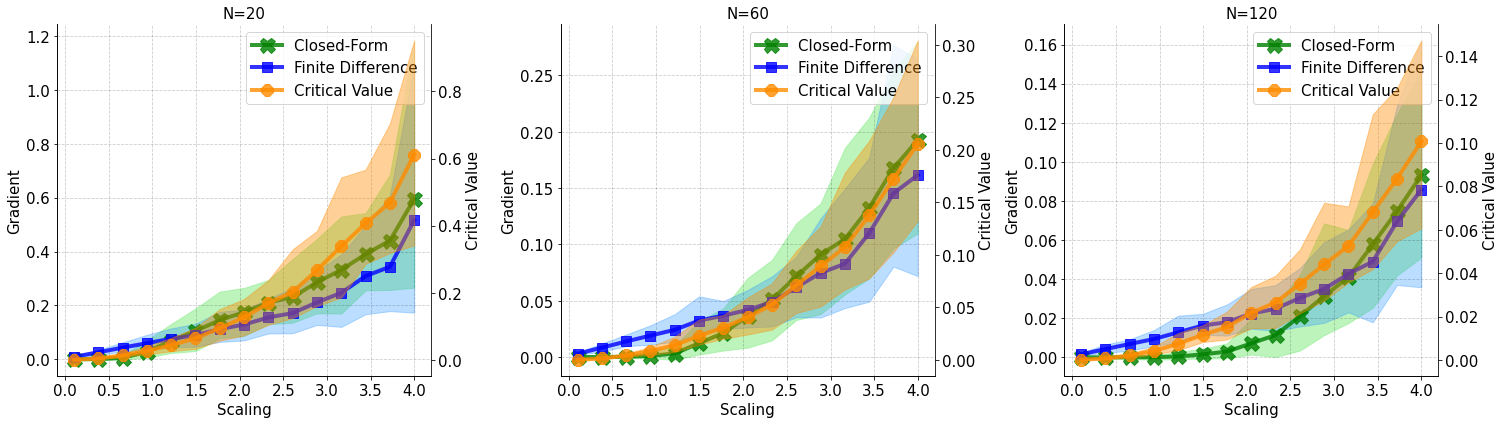

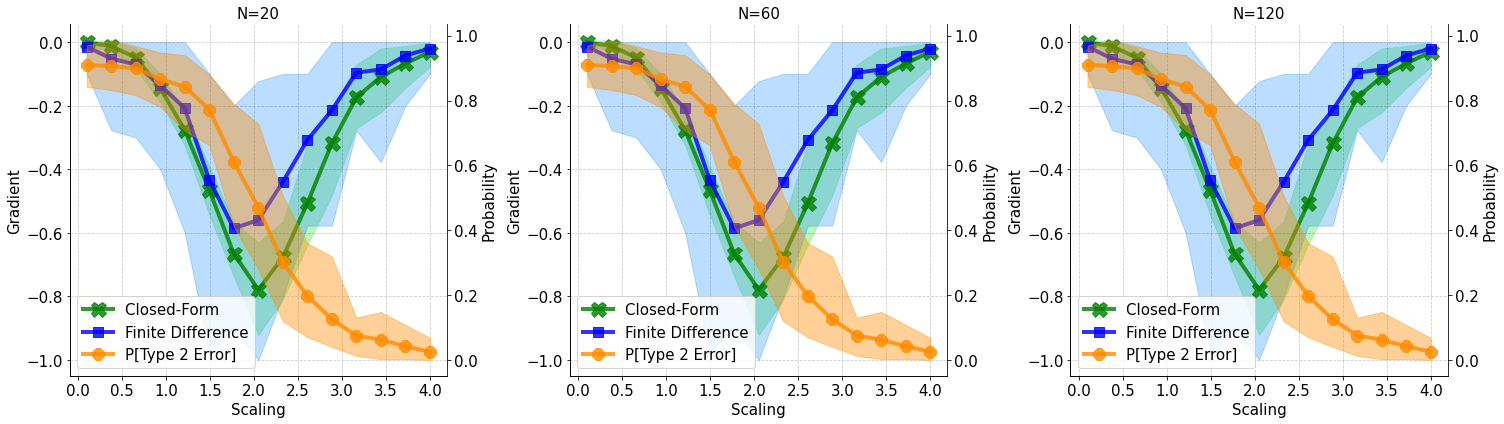

In [25]:
x_range = np.linspace(0.1, 4, 15)
xi_list = [1, 20, 100]
n_paths_list = [20, 60, 120]

colors = ['green', 'lightgreen', 'blue', 'dodgerblue']
label = 'Closed-Form '
target_label = 'Finite Difference'
alphas = [0.8, 0.6, 0.8, 0.3]
linewidths = [4, 4]
x_label = 'Scaling'
y_label = 'Gradient'

for xi in xi_list:

    fig, ax = plt.subplots(nrows=1, ncols=len(n_paths_list), figsize=(int(7*len(n_paths_list)), 6))
    for i, n_paths in enumerate(n_paths_list):
    
        crit_fd_data_dict = {}
        crit_emp_data_dict = {}
        type2error_fd_data_dict = {}
        type2error_emp_data_dict = {}
        crit_val_data_dict = {}
        prob_type2_data_dict = {}
        
        
        for j, scaling in enumerate(x_range):
    
            crit_fd_data_dict[scaling] = critval_grad_fd[n_paths][j]
            crit_emp_data_dict[scaling] = critval_grad_emp[n_paths][j][xi]
            type2error_fd_data_dict[scaling] = type2error_grad_fd[n_paths][j]
            type2error_emp_data_dict[scaling] = type2error_grad_emp[n_paths][j][xi]
            crit_val_data_dict[scaling] = crit_val_dict[n_paths][j]
            prob_type2_data_dict[scaling] = prob_type2_dict[n_paths][j]
    
        
        construct_plot(ax[i], crit_fd_data_dict, crit_emp_data_dict, x_range, alphas, colors, label, linewidths, x_label,
                       y_label, target_label, 
                       filename=None, alpha_ci=0.95, title=f'N={n_paths}')
        
        ax_twin = ax[i].twinx()
        ax_twin.plot(x_range, [np.nanmean(crit_val_data_dict[key]) for key in x_range], color='darkorange', 
                     alpha=0.8, linewidth=linewidths[0], label='Critical Value', marker='8', markersize=12)
    
        ci = compute_ci(crit_val_data_dict, x_range, alpha_ci=0.95)
        ax_twin.fill_between(x_range, np.asarray(ci)[:, 0], np.asarray(ci)[:, 1], color='darkorange', alpha=0.4)  
        ax_twin.set_ylabel('Critical Value', fontsize=15)
        ax_twin.spines["top"].set_visible(False)
        ax_twin.yaxis.set_ticks_position("right")
        ax_twin.xaxis.set_ticks_position("bottom")
        plt.setp(ax_twin.get_xticklabels(), fontsize=15)
        plt.setp(ax_twin.get_yticklabels(), fontsize=15)
        l1, t1 = ax[i].get_legend_handles_labels()
        l2, t2 = ax_twin.get_legend_handles_labels()
        ax[i].legend(l1 + l2, t1 + t2, fontsize="15", loc='best')

    plt.tight_layout()
    filename = f'ScaledBMImages/scaledbm_ub_grad_critval_025_035_{xi}.svg'
    file_path = Path(filename)
    file_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=len(n_paths_list), figsize=(int(7*len(n_paths_list)), 6))
    
    for i, n_paths in enumerate(n_paths_list):
        
        y_label = 'Gradient'
        construct_plot(ax[i], type2error_fd_data_dict, type2error_emp_data_dict, x_range, alphas, colors, label, linewidths, x_label, y_label, target_label, 
                       filename=None, alpha_ci=0.95, title=f'N={n_paths}')

        ax_twin = ax[i].twinx()
        ax_twin.plot(x_range, [np.nanmean(prob_type2_data_dict[key]) for key in x_range], color='darkorange', 
                     alpha=0.8, linewidth=linewidths[0], label='P[Type 2 Error]', marker='8', markersize=12)
    
        ci = compute_ci(prob_type2_data_dict, x_range, alpha_ci=0.95)
        ax_twin.fill_between(x_range, np.asarray(ci)[:, 0], np.asarray(ci)[:, 1], color='darkorange', alpha=0.4)  
        ax_twin.set_ylabel('Probability', fontsize=15)
        ax_twin.spines["top"].set_visible(False)
        ax_twin.yaxis.set_ticks_position("right")
        ax_twin.xaxis.set_ticks_position("bottom")
        plt.setp(ax_twin.get_xticklabels(), fontsize=15)
        plt.setp(ax_twin.get_yticklabels(), fontsize=15)
        l1, t1 = ax[i].get_legend_handles_labels()
        l2, t2 = ax_twin.get_legend_handles_labels()
        ax[i].legend(l1 + l2, t1 + t2, fontsize="15", loc='lower left')

        
    plt.tight_layout()
    filename = f'ScaledBMImages/scaledbm_ub_grad_025_035_{xi}.svg'
    file_path = Path(filename)
    file_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

## Compute Gradient under Null Hypothesis <a class="anchor" id="grad-H0"></a>

In [ ]:
sig = 0.25
beta = 0.27

T = 1
grid_points = 29

path_bank_size = 10000
   
h0_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, sig, path_bank_size, grid_points, T)), 0, 1).to(device=device)
h1_paths = torch.transpose(torch.from_numpy(generate_scaled_brownian_motion_paths(0.0, beta, path_bank_size, grid_points, T)), 0, 1).to(device=device)

n_paths_list = [120]
xi_list = [100]
scaling_range = np.linspace(0.1, 8, 15)


num_sim = 50

critval_grad_fd, type2error_grad_fd, critval_grad_emp, type2error_grad_emp, crit_val_dict, prob_type2_dict = generate_grad(h0_paths,
                                                                                                                           h1_paths, 
                                                                                                                           scaling_range,
                                                                                                                           xi_list,
                                                                                                                           n_paths_list, 
                                                                                                                           signature_kernel, 
                                                                                                                           num_sim=num_sim, 
                                                                                                                           device=device)

Save simulations.

In [21]:
with open('ScaledBMData/grad_mmd_computations_scaledbm_025_027.pkl', 'wb') as f:
    pickle.dump([critval_grad_fd, type2error_grad_fd, critval_grad_emp, type2error_grad_emp, crit_val_dict, prob_type2_dict], f)

Load simulations. 

In [17]:
with open('ScaledBMData/grad_mmd_computations_scaledbm_025_027.pkl', 'rb') as f:
    grad_data = pickle.load(f)

critval_grad_fd = grad_data[0]
type2error_grad_fd = grad_data[1]
critval_grad_emp = grad_data[2]
type2error_grad_emp = grad_data[3]
crit_val_dict = grad_data[4]
prob_type2_dict = grad_data[5]

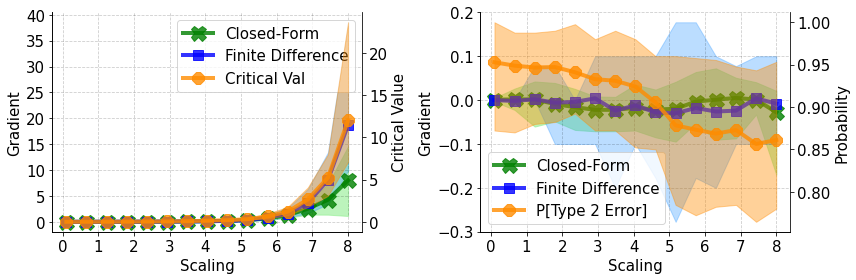

In [23]:
x_range = np.linspace(0.1, 8, 15)
xi_list = [100]
n_paths_list = [120]
for xi in xi_list:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for i, n_paths in enumerate(n_paths_list):
    
        crit_fd_data_dict = {}
        crit_emp_data_dict = {}
        type2error_fd_data_dict = {}
        type2error_emp_data_dict = {}
        crit_val_data_dict = {}
        prob_type2_data_dict = {}
        
        
        for j, scaling in enumerate(x_range):
    
            crit_fd_data_dict[scaling] = critval_grad_fd[n_paths][j]
            crit_emp_data_dict[scaling] = critval_grad_emp[n_paths][j][xi]
            type2error_fd_data_dict[scaling] = type2error_grad_fd[n_paths][j]
            type2error_emp_data_dict[scaling] = type2error_grad_emp[n_paths][j][xi]
            crit_val_data_dict[scaling] = crit_val_dict[n_paths][j]
            prob_type2_data_dict[scaling] = prob_type2_dict[n_paths][j]
    
        colors = ['green', 'lightgreen', 'blue', 'dodgerblue']
        label = 'Closed-Form'
        target_label = 'Finite Difference'
        alphas = [0.8, 0.6, 0.8, 0.3]
        linewidths = [4, 4]
        x_label = 'Scaling'
        y_label = 'Gradient'

        if len(n_paths_list) == 1:
            current_ax = ax[0]
        else:
            current_ax = ax[0, i]
        
        construct_plot(current_ax, crit_fd_data_dict, crit_emp_data_dict, x_range, alphas, colors, label, linewidths, x_label,
                       y_label, target_label, 
                       filename=None, alpha_ci=0.95, title=None)
        
        ax_twin = current_ax.twinx()
            
        ax_twin.plot(x_range, [np.nanmean(crit_val_data_dict[key]) for key in x_range], color='darkorange', 
                     alpha=0.8, linewidth=linewidths[0], label='Critical Val', marker='8', markersize=12)
    
        ci = compute_ci(crit_val_data_dict, x_range, alpha_ci=0.95)
        ax_twin.fill_between(x_range, np.asarray(ci)[:, 0], np.asarray(ci)[:, 1], color='darkorange', alpha=0.4)  
        ax_twin.set_ylabel('Critical Value', fontsize=15)
        ax_twin.spines["top"].set_visible(False)
        ax_twin.yaxis.set_ticks_position("right")
        ax_twin.xaxis.set_ticks_position("bottom")
        plt.setp(ax_twin.get_xticklabels(), fontsize=15)
        plt.setp(ax_twin.get_yticklabels(), fontsize=15)
        l1, t1 = current_ax.get_legend_handles_labels()
        l2, t2 = ax_twin.get_legend_handles_labels()
        current_ax.legend(l1 + l2, t1 + t2, fontsize="15")
        
    
        y_label = 'Gradient'

        if len(n_paths_list) == 1:
            current_ax = ax[1]
        else:
            current_ax = ax[1, i]
            
        
        construct_plot(current_ax, type2error_fd_data_dict, type2error_emp_data_dict, x_range, alphas, colors, label, linewidths, x_label, y_label, target_label, 
                       filename=None, alpha_ci=0.95, title=None)

        ax_twin = current_ax.twinx()
            
        ax_twin.plot(x_range, [np.nanmean(prob_type2_data_dict[key]) for key in x_range], color='darkorange', 
                     alpha=0.8, linewidth=linewidths[0], label='P[Type 2 Error]', marker='8', markersize=12)
    
        ci = compute_ci(prob_type2_data_dict, x_range, alpha_ci=0.95)
        ax_twin.fill_between(x_range, np.asarray(ci)[:, 0], np.asarray(ci)[:, 1], color='darkorange', alpha=0.4)  
        ax_twin.set_ylabel('Probability', fontsize=15)
        ax_twin.spines["top"].set_visible(False)
        ax_twin.yaxis.set_ticks_position("right")
        ax_twin.xaxis.set_ticks_position("bottom")
        plt.setp(ax_twin.get_xticklabels(), fontsize=15)
        plt.setp(ax_twin.get_yticklabels(), fontsize=15)
        l1, t1 = current_ax.get_legend_handles_labels()
        l2, t2 = ax_twin.get_legend_handles_labels()
        current_ax.legend(l1 + l2, t1 + t2, fontsize="15", loc='lower left')

        
    plt.tight_layout()
    filename = f'ScaledBMImages/scaledbm_ub_grad_025_027_{xi}.svg'
    file_path = Path(filename)
    file_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()